# Produce the matrices on dev set
The dev (develpoment) set is mentioned in "Machine Learning Yearning" (Andrew Ng), refering to the hold-out cross validation set. Using dev set can keep the transcendence of the test set because we are still trying to improve our model's performance.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
plt.style.use('seaborn-colorblind')
#mpl.rcParams['xtick.labelsize'] = 8
#mpl.rcParams["image.cmap"] = 'gray'
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

import datetime
date = datetime.datetime.now().strftime('%Y%m%d')

%matplotlib inline

# Build data sets
Basically the data set need to be splitted into three subsets, training, dev and test set. To be consistent to the previous work, I adopt the split script to split the data set into training and test sets first. Since I choose to use one of the 5-fold CV as the dev set, I need to split the training set into "real" training and dev sets, following the split script of CV. `my_group_stratify_shuffle` is modified from `my_group_stratify_shuffle` to get index directly. Also, the model need to be retrained only using the "real" training set instead of the optimal model using the whole training set (i.e. including the dev set) to build.

In [2]:
from split import *
data_df = pd.read_csv('data/XRF_ML_cr.csv')
X = data_df.iloc[:, 1:-2].values
y = data_df['facies_merge_2'].values
groups = data_df['core_section'].values

train_idx, test_idx = my_train_test_split(y, groups)
X_train = X[train_idx]
y_train = y[train_idx]
groups_train = groups[train_idx]

In [8]:
trainn_idx, dev_idx = my_group_stratify_shuffle(X_train, y_train, groups_train)
X_trainn = X[train_idx[trainn_idx]]
X_dev = X[train_idx[dev_idx]]
y_trainn = y[train_idx[trainn_idx]]
y_dev = y[train_idx[dev_idx]]

## Check if the idex are fine

In [7]:
trainn_idx

array([     0,      1,      2, ..., 130867, 130868, 130869])

In [22]:
print(X_trainn.shape, X_dev.shape, y_trainn.shape, y_dev.shape)

(109262, 24) (21608, 24) (109262,) (21608,)


In [9]:
print(len(X_trainn), len(X_dev), len(X_trainn)+len(X_dev), len(X_train))

109262 21608 130870 130870


In [33]:
print('section no. in training set: ', len(np.unique(groups[train_idx[trainn_idx]])))
print('section no. in dev set: ', len(np.unique(groups[train_idx[dev_idx]])))

section no. in training set:  249
section no. in dev set:  48


In [37]:
print('Is there any duplicated section between training and dev sets?')
data_df['core_section'][train_idx[trainn_idx]].isin(np.unique(groups[train_idx[dev_idx]])).any()

Is there any duplicated section between training and dev sets?


False

# Predict labels in dev set
The model (roll_svc_trainn_model_20210511.joblib) is built by `build_trainn_svc.py` and `submit_svc_trainn.sh`.

In [17]:
from joblib import load
svc = load('models/roll_svc_trainn_model_20210511.joblib')

In [20]:
y_dev_pred = svc.predict(X_dev)
y_trainn_pred = svc.predict(X_trainn)

In [21]:
from sklearn.metrics import balanced_accuracy_score as score
print('Balanced score of training set: {:.2f}'.format(score(y_true=y_trainn, y_pred=y_trainn_pred)))
print('Balanced score of dev set: {:.2f}'.format(score(y_true=y_dev, y_pred=y_dev_pred)))

Balanced score of training set: 0.87
Balanced score of dev set: 0.63


Hmm...it has overfitting issue as expected. Modifying input features based on insights from error analysis might help, or use CA to transform the dataset.

# Produce matrices
The functions are adopted from ML_element_05.ipynb.

In [23]:
facies = ['shoreface', 'channel', 'beach-foreshore', 'sand flat', 'mud flat',
       'lagoon', 'peat', 'soil', 'eolian/fluvial (W)',
       'shallow marine', 'moraine', 'eolian/fluvial']

Facies = []
for fa in facies:
    Facies.append(fa.capitalize())

Facies

['Shoreface',
 'Channel',
 'Beach-foreshore',
 'Sand flat',
 'Mud flat',
 'Lagoon',
 'Peat',
 'Soil',
 'Eolian/fluvial (w)',
 'Shallow marine',
 'Moraine',
 'Eolian/fluvial']

In [24]:
def plot_recall(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test)
    """
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import balanced_accuracy_score as score

    for col in y_preds:
        # make confusion matrix between prediction and actual labels
        confusion = confusion_matrix(data_df.y, data_df[col])
        model_name = col[2:]
        con_df = pd.DataFrame(confusion, index = Facies, columns = Facies)
        #con_df.to_csv('results/roll_confusion_{}_{}.csv'.format(model_name, date))

        # normalize the counts ineach row and present in percent
        x = np.copy(confusion).astype(float)
        x /= x.sum(axis = 1, keepdims = True)
        con_per = pd.DataFrame((x*100).astype(int), index = Facies, columns = Facies)
        #con_per.to_csv('results/roll_recall_%_{}_{}.csv'.format(model_name, date))

        # Plot the matrix
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(con_per, annot = con_per.astype(str), ax = ax, cmap = 'GnBu', square = True, vmin=0, vmax=100,
                    xticklabels = con_per.index, yticklabels = con_per.columns, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Data percentage in each row'}
                   )

        ax.set_xlabel('Prediction (accuracy: {:.2f})'.format(score(y_true=data_df.y, y_pred=data_df[col])), size = 14)
        ax.set_ylabel('Actual facies', size = 14)
        fig.savefig('results/roll_{}_recall_%_{}_{}.png'.format(split, model_name, date))

In [30]:
y_df = pd.DataFrame(y_dev, columns=['y'])
y_df['y_svc'] = y_dev_pred
y_df['core_section'] = groups[train_idx[dev_idx]]

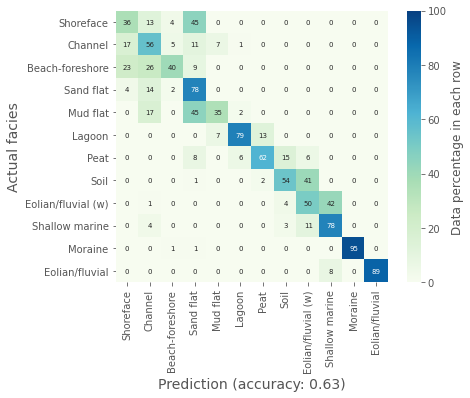

In [27]:
plot_recall(y_df, ['y_svc'], Facies, 'dev')

In [28]:
def detect_conjuction(data_df, y_preds, Facies, split):
    """
    data_df is the dataframe having info and labels.
    y_preds is a list of the column names of labels you want to plot.
    Faceis is a list of facies names.
    split is the name of the dataset, which used for filename (train or test).
    """
    
    data_df['id'] = range(len(data_df))
    mat_dict = {}


    for y_pred in y_preds:
        y_mean = []
        composite_id = []
        model_name = y_pred[2:] if len(y_pred)>1 else 'description'
        
        for section in np.unique(data_df.core_section):
            y_mean = np.hstack((y_mean, data_df.loc[data_df.core_section == section, y_pred].rolling(window = 2).mean()))
            composite_id = np.hstack((composite_id, data_df[data_df.core_section == section].index))

        # merge the rolling with the original label
        # this will lost the first data poit in each section, but it doesn't mater
        # because the boundary shouldn't be at the begining of each section
        tmp_df = pd.concat([data_df, pd.DataFrame({'y_mean': y_mean}, index = composite_id).dropna()], join = 'inner', axis = 1)

        # if y_pred is not same as y_mean, it means there is a boundary (facies change) between this and above depth
        bd_df = tmp_df[tmp_df[y_pred] != tmp_df.y_mean].copy()
        bd_df['ab_id'] = bd_df.id - 1
        if len(model_name) > 3:
            print('There are {} boundaries in description.'.format(len(bd_df)))
        else:
            print('There are {} boundaries in the optimized {} model\'s predictions.'.format(len(bd_df), model_name))

        # build matrix of boundaries
        bd_mat = np.zeros(shape = (12, 12), dtype = int)

        for row in bd_df.iterrows():
            tmp = np.zeros(shape = (12, 12), dtype = int)
            tmp[data_df[y_pred][int(row[1].ab_id)], data_df[y_pred][int(row[1].id)]] = 1
            bd_mat += tmp
            
        mat_dict[y_pred] = bd_mat
        
        # plot
        fig, ax = plt.subplots(1, 1, figsize = (7, 5))
        sns.heatmap(bd_mat, annot = bd_mat.astype(str), ax = ax, cmap = 'Greens', square = True, #vmin=0, vmax=130,
                    xticklabels = Facies, yticklabels = Facies, fmt = 's', 
                    annot_kws={'size': 7}, cbar_kws = {'label' : 'Counts (total: {})'.format(len(bd_df))}
                   )
        ax.set_xlabel('Below facies', size = 16)
        ax.set_ylabel('Above facies', size = 16)
        fig.savefig('results/roll_{}_conjunction_matrix_{}_{}.png'.format(split, model_name, date))
    
    return mat_dict

There are 22 boundaries in description.
There are 1032 boundaries in the optimized svc model's predictions.


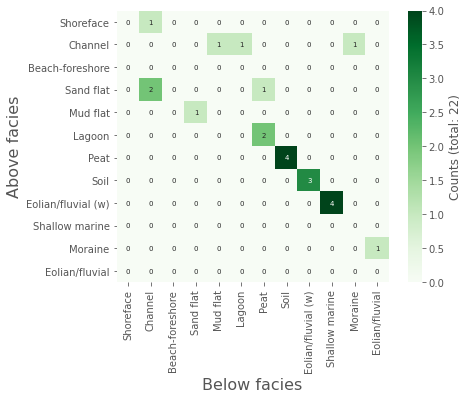

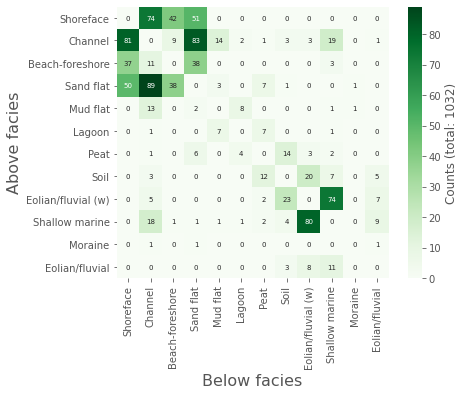

In [31]:
mat_dict = detect_conjuction(y_df,  ['y', 'y_svc'], Facies, 'dev')